# Comprendre auto-codeurs de débruitage, et pourquoi les utiliser ?

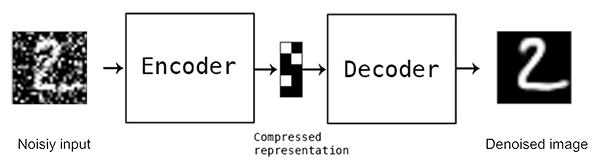

[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

# Importation des packages

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2

In [2]:
def autoencoder_model(width, height, depth, latentDim=16):

  inputShape = (height, width, depth)
  chanDim = -1
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=-1)(x)

  volumeSize = K.int_shape(x)

  x = Flatten()(x)
  latent = Dense(latentDim)(x)
  encoder = Model(inputs, latent, name="encoder")

  latentInputs = Input(shape=(latentDim,))

  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  x = Conv2DTranspose(64, (3, 3), strides=2,
  			padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Conv2DTranspose(32, (3, 3), strides=2,
  	padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)

  # A changer !
  outputs = Activation("sigmoid")(x)

  decoder = Model(latentInputs, outputs, name="decoder")

  autoencoder = Model(inputs, decoder(encoder(inputs)),
  	name="autoencoder")

  return (encoder, decoder, autoencoder)

In [3]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [5]:
(encoder, decoder, autoencoder) = autoencoder_model(28, 28, 1)


In [7]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256 

In [8]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        1846

In [6]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69392     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [ ]:
(encoder, decoder, autoencoder) = autoencoder_model(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
1875/1875 [==============================] - 170s 90ms/step - loss: 0.0307 - val_loss: 0.0197
Epoch 2/25
1875/1875 [==============================] - 168s 89ms/step - loss: 0.0190 - val_loss: 0.0181
Epoch 3/25
1875/1875 [==============================] - 167s 89ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 4/25
1875/1875 [==============================] - 168s 90ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 5/25
1875/1875 [==============================] - 168s 90ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 6/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 7/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0163 - val_loss: 0.0183
Epoch 8/25
1875/1875 [==============================] - 168s 90ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 9/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 10/25
1875/1875 [==============================] 

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

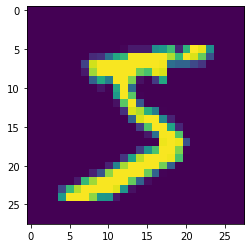

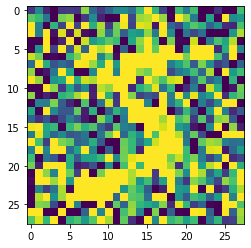

In [ ]:
plt.imshow(trainX[0, :, :, 0])
plt.show()
plt.imshow(trainXNoisy[0, :, :, 0])
plt.show()

In [ ]:
pred = autoencoder(np.expand_dims(trainXNoisy[0, :, :, :], axis=0))

In [ ]:
latent_space = encoder(np.expand_dims(trainXNoisy[0, :, :, :], axis=0))
image = decoder(latent_space)

In [ ]:
model = Sequential([Input(28, 28, 1), 
                    encoder, 
                    Dense(10, activation='softmax')])

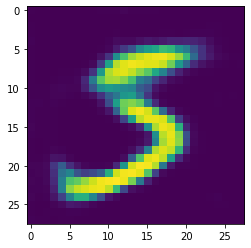

In [ ]:
plt.imshow(pred[0, :, :, 0])
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>